# Dependencies

In [ ]:
!pip install bertopic --quiet
!pip install wandb
!pip install matplotlib==3.4.3
import wandb
from datasets import load_from_disk
from bertopic import BERTopic
import seaborn as sns
import matplotlib.pyplot as plt

#run = wandb.init(project='Question_Generation',entity=None, job_type='EDA',name='EDA')

In [ ]:
ds_reduced_emb=load_from_disk('./data/asks_cleaned_data')
df_train=ds_reduced_emb['train'].to_pandas()

del ds_reduced_emb

# EDA

## Data Leakage

In [ ]:
raw_data=load_from_disk('./data/asks_raw_data')

In [ ]:
i=36
print(f"TITLE: {raw_data['train'][i]['title']}")
print(f"TEXT: {raw_data['train'][i]['selftext']}")
print('\n','==========='*10,'\n')
print(f"ANSWER: {raw_data['train'][i]['answers.text'][0]}")

## Topic Modeling

In [ ]:
#raw_data=load_from_disk('./data/asks_raw_data')

In [ ]:
#ds_reduced_emb=load_from_disk('./data/asks_cleaned_data')
#df_train=ds_reduced_emb['train'].to_pandas()
#del ds_reduced_emb

In [ ]:
docs=list(df_train['answers.text'])
embs=df_train['sent_vec'].to_numpy()
embs=np.stack(embs, axis=0)

In [ ]:
topic_model=BERTopic()
topics,probs=topic_model.fit_transform(docs,embs)

In [ ]:
topic_model.save('./asks_topic_modelV2')

In [ ]:
topic_model = BERTopic.load('./asks_topic_model')

In [ ]:
topic_model_plot=topic_model.visualize_topics(top_n_topics=20)
topic_model_plot.update_layout(title='')
#wandb.log({"Topic Model": topic_model_plot})

In [ ]:
topic_model_plot=topic_model.visualize_topics(top_n_topics=50)
topic_model_plot

In [ ]:
topic_heatmap=topic_model.visualize_heatmap(n_clusters=1, top_n_topics=20)
#topic_heatmap.update_layout(title='')
#wandb.log({"Topic Model Heatmap": topic_heatmap})

In [ ]:
topic_heatmap

In [ ]:
topic_model_barchart=topic_model.visualize_barchart(top_n_topics=10)
#plt.tight_layout()
#wandb.log({"Topic Model Barchart": topic_model_barchart})

<Figure size 640x480 with 0 Axes>

In [ ]:
topic_model_barchart

## Stats

### Scores

In [ ]:
df_train['answers.score'].describe()

count    125323.000000
mean         65.002186
std         494.340139
min           2.000000
25%           3.000000
50%           6.000000
75%          13.000000
max       32734.000000
Name: answers.score, dtype: float64

In [ ]:
df_train['answers.score'].value_counts()

2        20128
3        18835
5        10084
4         9361
6         8275
         ...  
636          1
856          1
6025         1
4528         1
11385        1
Name: answers.score, Length: 2317, dtype: int64

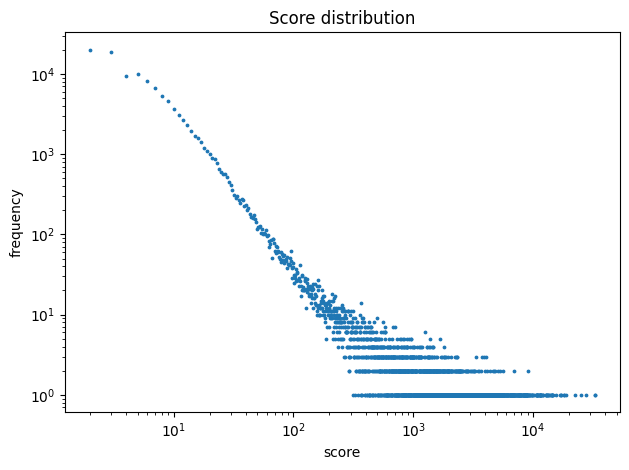

In [ ]:
y=list(df_train['answers.score'].value_counts())
x=list(df_train['answers.score'].value_counts().index)

dist_plot=plt.scatter(x=x,y=y,s=3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('score')
plt.ylabel('frequency')
plt.title('Score distribution')
plt.tight_layout()
plt.savefig('./figures/score_distribution')

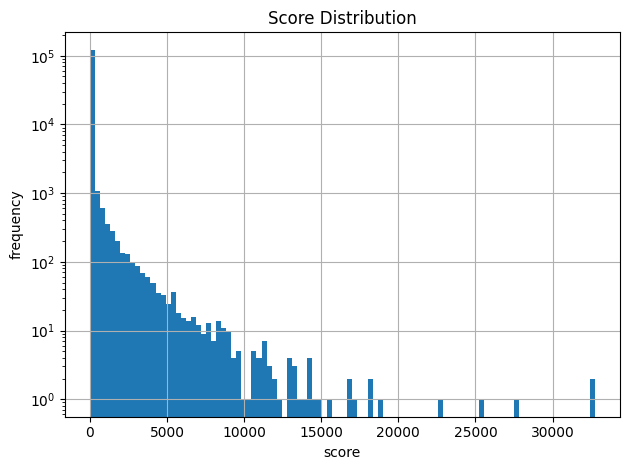

In [ ]:
df_train['answers.score'].hist(bins=100)
plt.yscale('log')
plt.xlabel('score')
plt.ylabel('frequency')
plt.title('Score Distribution')
plt.tight_layout()
plt.savefig('./figures/hist_answers')

### URLs

In [ ]:
def get_site(list_urls):
    return [urlparse(url).netloc if urlparse(url).netloc!='' 
            else urlparse(url).path
            for url in list_urls]

In [ ]:
url_counts_answers=df_train['answers_urls.url']
url_counts_answers=url_counts_answers.map(len)
url_counts_answers=df_train['answers_urls.url'][url_counts_answers!=0].map(
    get_site).explode().value_counts()[:20].to_frame()

url_counts_answers=url_counts_answers.reset_index().rename(columns={'index':'URL',
                                         'answers_urls.url':'frequency'})
run.log({'Common URLs in Answers':
         wandb.Table(dataframe=url_counts_answers)})

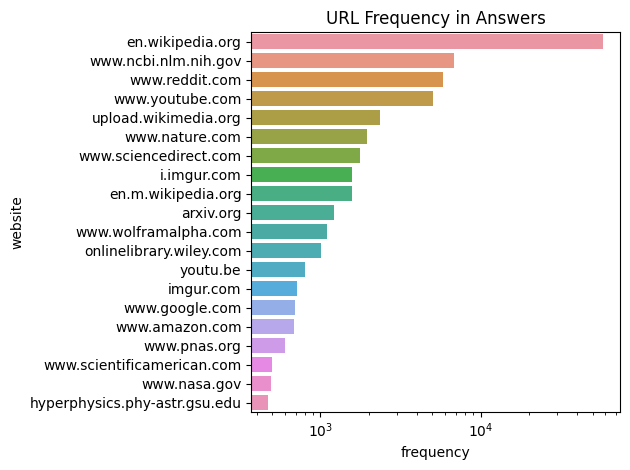

In [ ]:
sns.barplot(x=list(url_counts)[:20]
            ,y=url_counts.index[:20])
plt.ylabel('website')
plt.xlabel('frequency')
plt.title('URL Frequency in Answers')
plt.xscale('log')
plt.tight_layout()
plt.savefig('./figures/answer_URL_Freq')
plt.show()

In [ ]:
url_counts_answers=df_train['answers_urls.url']
url_counts_answers=url_counts_answers.map(len)
url_counts_answers=df_train['answers_urls.url'][url_counts_answers!=0].map(
    get_site).explode().value_counts()[:20].to_frame()

url_counts_answers

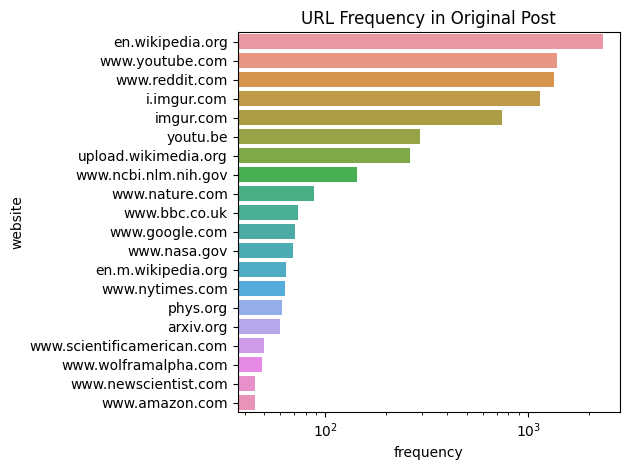

In [ ]:
sns.barplot(x=list(url_counts)[:20]
            ,y=url_counts.index[:20])
plt.ylabel('website')
plt.xlabel('frequency')
plt.title('URL Frequency in Original Post')
plt.xscale('log')
plt.tight_layout()
plt.savefig('./figures/question_URL_Freq')
plt.show()

In [ ]:
url_counts_selftext=df_train['selftext_urls.url']
url_counts_selftext=url_counts_selftext.map(len)
url_counts_selftext=df_train['selftext_urls.url'][url_counts_selftext!=0].map(
    get_site).explode().value_counts()[:20].to_frame()

url_counts_selftext

### Answer Length

In [ ]:
df_train['selftext_len']=df_train['selftext'].str.split().map(len)
df_train['answers_text_len']=df_train['answers.text'].str.split().map(len)
df_train['title_len']=df_train['title'].str.split().map(len)

In [ ]:
correlation_table=df_train[['answers.score','selftext_len','answers_text_len','title_len']].corr()

In [ ]:
df_train['answers_text_len'].describe()

count    125323.000000
mean        146.587243
std         138.798567
min          21.000000
25%          60.000000
50%         103.000000
75%         182.000000
max        1957.000000
Name: answers_text_len, dtype: float64

In [ ]:
df_train['title_len'].describe()

count    125323.000000
mean         15.007373
std           8.179351
min           1.000000
25%           9.000000
50%          13.000000
75%          19.000000
max          63.000000
Name: title_len, dtype: float64

In [ ]:
df_train['selftext_len'].describe()

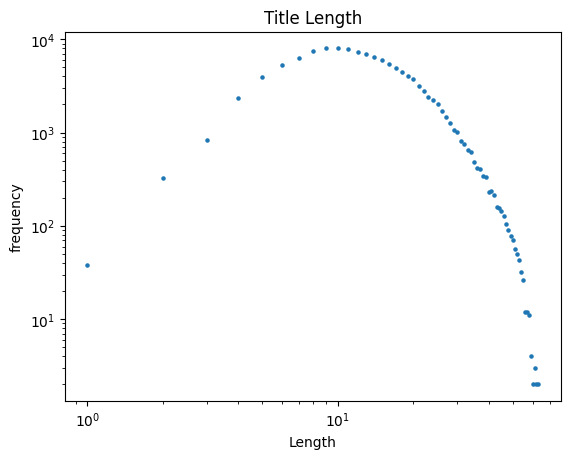

In [ ]:
y=list(df_train['title_len'].value_counts())
x=list(df_train['title_len'].value_counts().index)

dist_plot=plt.scatter(x=x,y=y,s=5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Length')
plt.ylabel('frequency')
plt.title('Title Length')
plt.savefig('./figures/title_length_scatter')

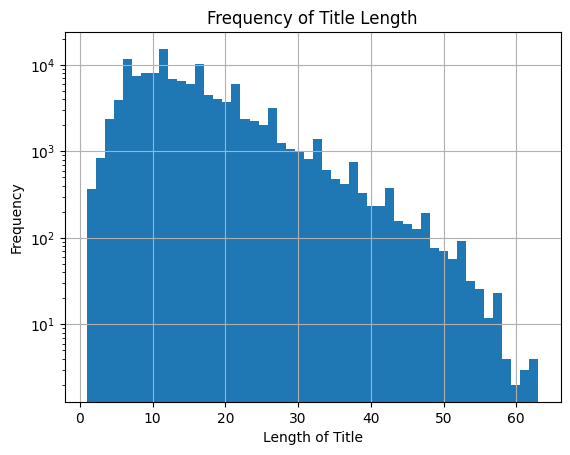

In [ ]:
df_train['title_len'].hist(bins=50)
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Frequency of Title Length')
plt.savefig('./figures/hist_title_len')
plt.show()

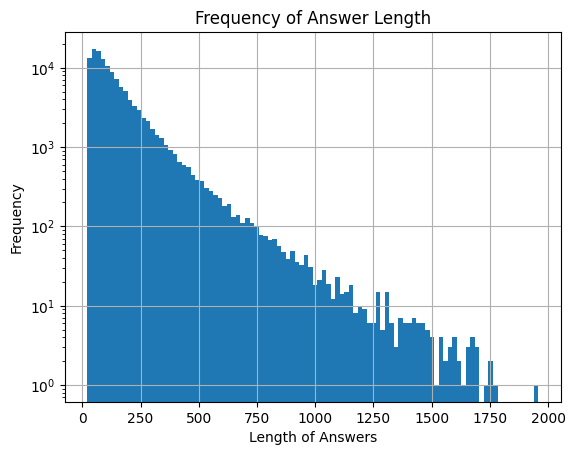

In [ ]:
df_train['answers_text_len'].hist(bins=100)
plt.xlabel('Length of Answers')
plt.ylabel('Frequency')
plt.title('Frequency of Answer Length')
plt.yscale('log')
plt.savefig('./figures/hist_answer_len')
plt.show()

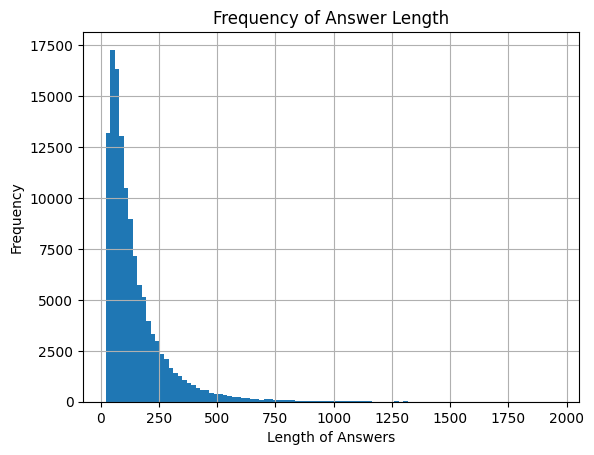

In [ ]:
df_train['answers_text_len'].hist(bins=100)
plt.xlabel('Length of Answers')
plt.ylabel('Frequency')
plt.title('Frequency of Answer Length')
plt.savefig('./figures/hist_answer_len_no_log')
plt.show()

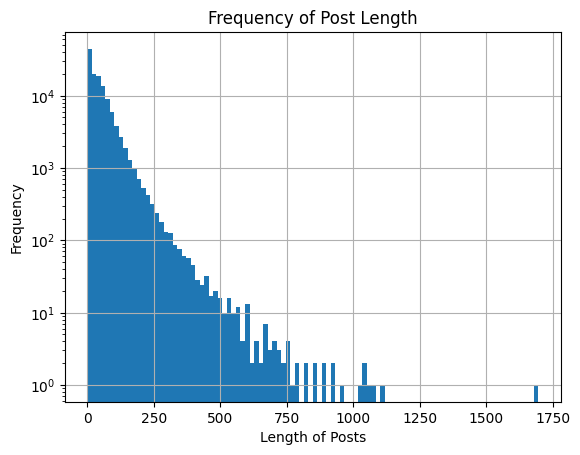

In [ ]:
df_train['selftext_len'].hist(bins=100)
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')
plt.title('Frequency of Post Length')
plt.yscale('log')
plt.savefig('./figures/hist_post_len')
plt.show()

In [ ]:
dataframe=df_train['selftext'].value_counts()[:10].to_frame()
dataframe.reset_index().rename(columns={'index':'text','selftext':'Frequency'})

,text,Frequency
0,,32506
1,[deleted],1172
2,[removed],352
3,_url_0_,168
4,.,60
5,title,50
6,title says it all.,20
7,?,19
8,title.,18
9,thanks!,18


In [ ]:
df_train['title'].value_counts()[:10].to_frame()

,title
why is technetium radioactive?,7
why is ice slippery?,7
what is energy?,6
how does soap work?,6
what is fire?,6
what would happen if two black holes collided?,6
how far away is the horizon?,5
how does glue work?,5
is sound affected by gravity?,5
how does anesthesia work?,4


In [ ]:
idxs_repeated_answers=df_train['answers.text'].value_counts().values>1

In [ ]:
len(df_train['answers.text'])

125323

In [ ]:
df_train['answers.text'].nunique()

125240

In [ ]:
len(df_train['answers.text'].value_counts()[idxs_repeated_answers])

69

In [ ]:
df_train['answers.text'].value_counts()[:1]

the feeling of satiety has some relation to stretch receptors registering stomach distention, but it is also very dependent on the caloric density of the meal: the above is selectively quoted from [this free-to-access review article](_url_2_). basically, satiety is determined by a number of signalling molecules derived from the gut that transmit information to the brain about how nutrient-rich the meal was. the text doesn't mention it, but abdominal distension (transmitted via the vagus nerve) is also important for satiety (see the caption for fig. 1). this paper also mostly addresses satiety signals - the most commonly referenced [orexigenic](_url_3_) trigger is [ghrelin](_url_1_) - [more info here](_url_4_). tl;dr: basically, molecules released from your gut + stretching of your stomach provide signals to your brain that tell you you're full. there are other molecular signals, particularly ghrelin, that address hunger, but that is often based on non-biologic factors.    5
Name: answe